## Cpu implementation of feed forward neural network for a trivial binary classification model with Pytorch 

In [1]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
from torch.optim import SGD
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix, classification_report

### Upload the dataset 

In [2]:
data = np.load('/Users/marcosalvalaggio/code/xeye/notebooks/data/TrivialBinaryClassification.npz')
data.files

['X_train', 'X_test', 'y_train', 'y_test']

In [3]:
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

In [4]:
# Dataset dimensions (num of images, height, width)
print(f'X_train dataset shape: {X_train.shape}')
print(f'X_test dataset shape: {X_test.shape}')

X_train dataset shape: (1600, 100, 100)
X_test dataset shape: (400, 100, 100)


In [5]:
# Labels 
print(y_train.shape)
print(y_test.shape)

(1600,)
(400,)


### Visualize a single image from train dataset 

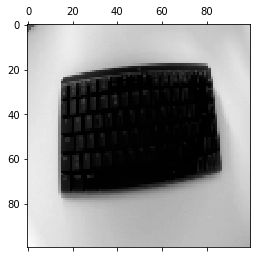

In [6]:
plt.matshow(X_train[100],cmap='gray')

Schema for map y values to category labels:

* keyboard = 0
* mouse = 1 

In [7]:
print(f'X_train[100]: {y_train[100]}')
print(f'Label for X_train[100]: keyboard')

X_train[100]: 0
Label for X_train[100]: keyboard


### Preprocessing 

In [8]:
#Min-max feature scaling = values of single pixel between [0,1] instead of [0 = black , 255 = white]
X_train = X_train / 255
X_test = X_test / 255

In [9]:
# First train dataset image scaled 
X_train[0,:,:]

array([[0.00392157, 0.00392157, 0.00392157, ..., 0.41176471, 0.4       ,
        0.30588235],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.41960784, 0.40392157,
        0.31764706],
       [0.01176471, 0.00784314, 0.00392157, ..., 0.42745098, 0.41568627,
        0.31764706],
       ...,
       [0.01960784, 0.12941176, 0.60392157, ..., 0.64313725, 0.63137255,
        0.63529412],
       [0.00784314, 0.00784314, 0.14117647, ..., 0.63529412, 0.63137255,
        0.62745098],
       [0.09411765, 0.00784314, 0.00784314, ..., 0.63137255, 0.62745098,
        0.62745098]])

Flatteing operation is necessary in order to pass the pixel values of the image to the input layer of the feed forward neural network. 

In [10]:
# Flattening
# dimensions = (num. of images, height x width)
X_train_flattened = X_train.reshape(len(X_train), 100*100)
X_test_flattened = X_test.reshape(len(X_test), 100*100)

In [11]:
print(f'X_train flattened dataset shape: {X_train_flattened.shape}')
print(f'X_test flattened dataset shape: {X_test_flattened.shape}')

X_train flattened dataset shape: (1600, 10000)
X_test flattened dataset shape: (400, 10000)


### Converting into Torch tensors and select the device (cpu or gpu)

In [12]:
# Conversion 
X_train_t = torch.tensor(X_train_flattened).float()
y_train_t = torch.tensor(y_train).float()
# Select available device 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# pass the objects into the device selected
X_train_t = X_train_t.to(device)
y_train_t = y_train_t.to(device)

In [13]:
print(f'X_train flattened Torch tensor: {X_train_t.shape}')
print(f'y_train Torch tensor: {y_train_t.shape}')

X_train flattened Torch tensor: torch.Size([1600, 10000])
y_train Torch tensor: torch.Size([1600])


### Defining dataset class

In [14]:
class MyDataset(Dataset):
    def __init__(self,x,y):
        #self.x = torch.tensor(x).float()
        #self.y = torch.tensor(y, dtype=torch.float)
        self.x = x.clone().detach().requires_grad_(True)
        self.y = y.clone().detach().requires_grad_(True)
    def __len__(self):
        return len(self.x)
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]
# create a MyDataset object 
ds = MyDataset(X_train_t, y_train_t)

### Create the dataloader 

In [15]:
batch_size = 800
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

### Define the network structure 

In [16]:
class FFNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_to_hidden_layer = nn.Linear(10000,100)
        self.hidden_layer_activation = nn.ReLU()
        self.hidden_to_output_layer = nn.Linear(100,1)
    def forward(self, x):
        x = self.input_to_hidden_layer(x)
        x = self.hidden_layer_activation(x)
        x = torch.sigmoid(self.hidden_to_output_layer(x))
        return x

mynet = FFNN().to(device)

### Forward pass on the untrained network

In [17]:
print(f'1) size of the image: {X_train_t[1].size()}')
print(f'2) label of the image: {y_train_t[1]} = keyboard')
print(f'3) value of the output node of the network: {mynet(X_train_t[0])}')
print(f'4) predicted class: {torch.round(torch.sigmoid(mynet(X_train_t[1])))} = mouse')

1) size of the image: torch.Size([10000])
2) label of the image: 0.0 = keyboard
3) value of the output node of the network: tensor([0.4628], grad_fn=<SigmoidBackward0>)
4) predicted class: tensor([1.], grad_fn=<RoundBackward0>) = mouse


### Define objective function and upgrade weights method 

In [18]:
loss_func = nn.BCELoss()
opt = SGD(mynet.parameters(), lr = 0.001)
epochs = 3

### Training loop

In [19]:
def accuracy_val(y_pred, y_val):

    y_pred_tag = np.array(y_pred.reshape(-1).detach()).round()
    y_val = np.array(y_val.detach())

    correct_results = np.sum(y_pred_tag == y_val)
    acc = correct_results/y_val.shape[0]
    acc = np.round(acc * 100)
    
    return acc

In [20]:
loss_history = []
acc_history = []
print('===========================================================')
for _ in range(epochs):
    numBatch = np.round(X_train_t.shape[0]/batch_size)
    batch = 1
    for data in dl:

        x, y = data
        opt.zero_grad()

        predicted = mynet(x)
        loss_value = loss_func(predicted, y.unsqueeze(1))
        acc_value = accuracy_val(predicted, y)


        loss_value.backward()
        opt.step()

        loss_history.append(loss_value)
        acc_history.append(acc_value)

        print(f'epoch: {_+1}/{int(epochs)} | batch: {batch}/{int(numBatch)} | loss: {loss_value} | accuracy: {acc_value}%')

        batch += 1

print('===========================================================')

epoch: 1/3 | batch: 1/2 | loss: 0.6835921406745911 | accuracy: 51.0%
epoch: 1/3 | batch: 2/2 | loss: 0.6745778918266296 | accuracy: 48.0%
epoch: 2/3 | batch: 1/2 | loss: 0.6590240001678467 | accuracy: 48.0%
epoch: 2/3 | batch: 2/2 | loss: 0.6431598663330078 | accuracy: 84.0%
epoch: 3/3 | batch: 1/2 | loss: 0.6357089281082153 | accuracy: 97.0%
epoch: 3/3 | batch: 2/2 | loss: 0.6184735298156738 | accuracy: 99.0%


### Label prediction for a new "virtual" image passed to the trained model 

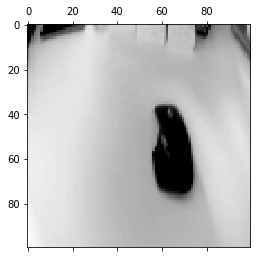

In [21]:
index = 1
plt.matshow(X_test[index],cmap='gray')

In [22]:
print(f'X_test[index]: {y_test[index]}')
print(f'Label for X_test[index]: mouse')

X_test[index]: 1
Label for X_test[index]: mouse


In [23]:
val_x = X_test_flattened[1]
val_x = torch.tensor(val_x).float().to(device)
print(type(val_x))

<class 'torch.Tensor'>


In [24]:
# label
y_test[1]

1

In [25]:
# prediction 
output = mynet(val_x)
output

tensor([0.5309], grad_fn=<SigmoidBackward0>)

In [26]:
# label predicted 
out = torch.round(torch.sigmoid(output))
out

tensor([1.], grad_fn=<RoundBackward0>)

### Prediction on Test dataset 

In [27]:
# Conversion 
X_test_t = torch.tensor(X_test_flattened).float()
y_test_t = torch.tensor(y_test).float()
# Select available device 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# pass the objects into the device selected
X_test_t = X_test_t.to(device)
y_test_t = y_test_t.to(device)

In [28]:
predicted_test = mynet(X_test_t)
predicted_test.shape

torch.Size([400, 1])

In [29]:
y_pred_test_tag = np.array(predicted_test.reshape(-1).detach()).round()
print(y_pred_test_tag.shape)
y_val_test = np.array(y_test_t.detach())
print(y_val_test.shape)

(400,)
(400,)


In [30]:
confusion_matrix(y_val_test, y_pred_test_tag)

array([[204,   3],
       [  0, 193]])

In [31]:
print(classification_report(y_val_test, y_pred_test_tag))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       207
         1.0       0.98      1.00      0.99       193

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400

